# GAN's

<h2> What is a GAN? </h2>

The Generative Adversarial Network was invented by Ian Goodfellow, where two networks play a game. In our case, we will build a 'crappifier' to make images worse, and the critic will try to determine which is fake and which is the original. This will help us achieve *super-resolution*

In [0]:
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

## Crappified Data

In [0]:
from PIL import Image, ImageDraw, ImageFont

class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        targ_sz = resize_to(img, 96, use_min=True)
        img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,70)
        ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
        img.save(dest, quality=q)

In [0]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

In [0]:
il = ImageList.from_folder(path_hr)
parallel(crappifier(path_lr, path_hr), il.items)

In [0]:
bs, size = 32, 128
#bs, size = 24, 160
#bs, size = 8, 256
arch = models.resnet34

## Pretrained-Generator

We need a generator to make our images look worse

In [0]:
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [0]:
def get_data(bs, size):
  data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

  data.c = 3
  return data

In [0]:
data_gen = get_data(bs, size)

On the left is our 'crappified', on the right is the original

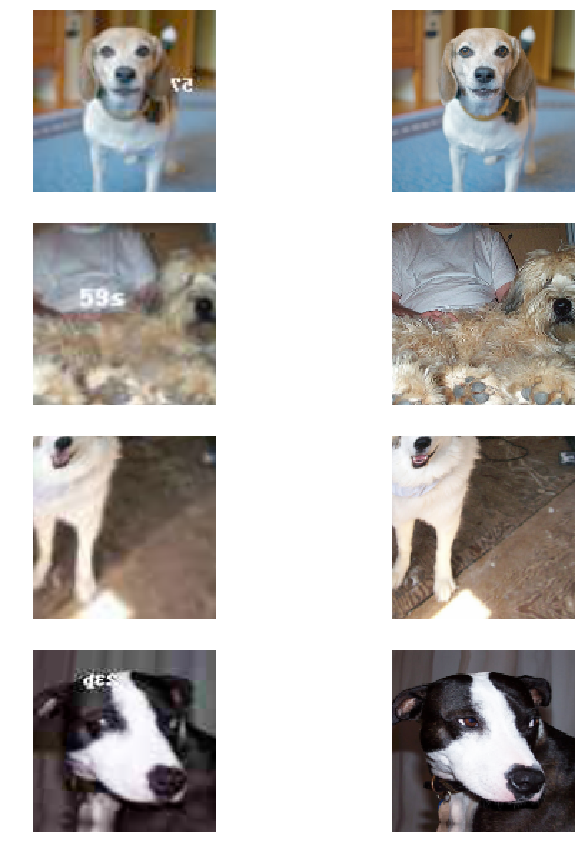

In [16]:
data_gen.show_batch(4, figsize=(12,12))

Now, what our endgoal is to do here is make the left image look like the right.

## Hyper-Parameters and Architecture

In [0]:
wd, y_range, loss_gen = 1e-3, (-3., 3.), MSELossFlat()

In [0]:
def create_gen_learner():
  return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                     self_attention=True, y_range=y_range, loss_func = loss_gen)

In [0]:
learn_gen = create_gen_learner()

In [28]:
learn_gen.model

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum

![alt text](https://docs.fast.ai/imgs/u-net-architecture.png)

In [29]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

epoch,train_loss,valid_loss,time
0,0.068469,0.060192,02:05
1,0.058869,0.050615,01:58


Unfreeze

In [0]:
learn_gen.unfreeze()

In [31]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

epoch,train_loss,valid_loss,time
0,0.053320,0.048455,01:59
1,0.049938,0.045194,02:00
2,0.048577,0.044486,01:57


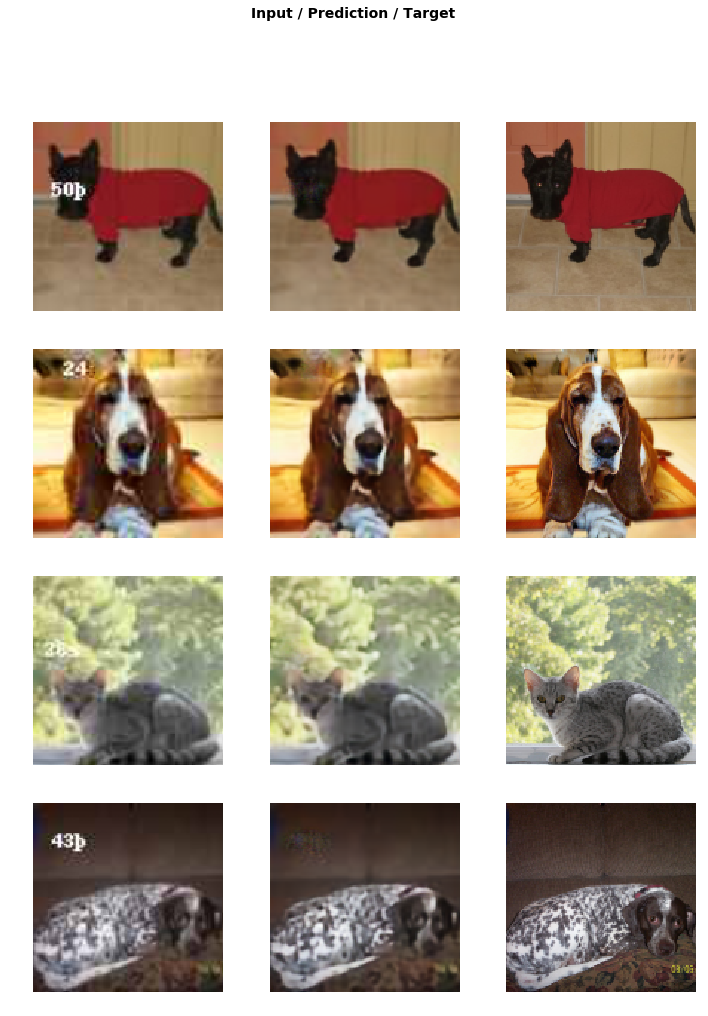

In [32]:
learn_gen.show_results(rows=4)

In [0]:
learn_gen.save('gen-pre2')

## Save our newly generated image set

In [0]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [0]:
path_gen.mkdir(exist_ok=True)

In [0]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [0]:
save_preds(data_gen.fix_dl)

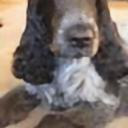

In [39]:
PIL.Image.open(path_gen.ls()[0])

# Train the Critic

In [40]:
learn_gen = None
gc.collect()

22577

First we will pretrain the critic on crappy vs non crappy

In [0]:

def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [0]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

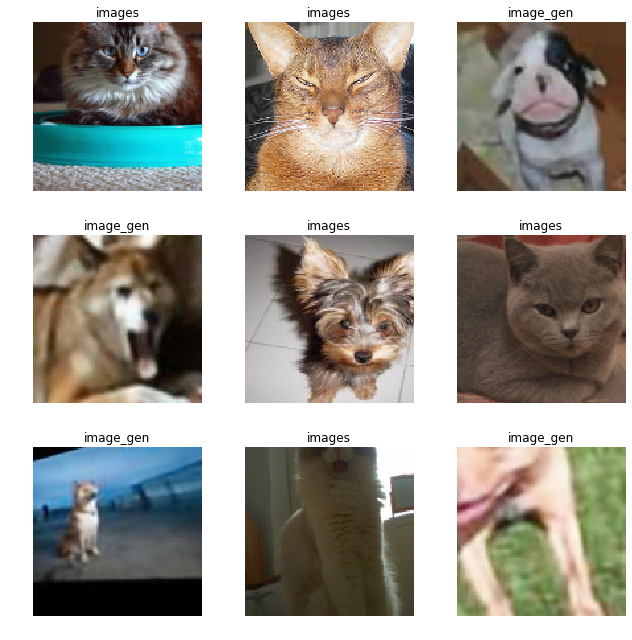

In [43]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [0]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

## Create the Critic

In [0]:
def create_critic_learner(data, metrics):
  return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [0]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [49]:
learn_critic.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.645922,0.621811,0.679658,03:52
1,0.267871,0.742754,0.712706,03:47
2,0.142937,0.140112,0.964615,03:46


Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

KeyboardInterrupt: ignored

In [0]:
learn_critic.save('critic-pre2')

# GAN

Now that we have two models, we can create our GAN

In [51]:
learn_crit = None
learn_gen = None
gc.collect()

18387

In [0]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)

In [0]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2');

In [0]:
learn_gen = create_gen_learner().load('gen-pre2');

The last thing to do is to define our GAN. We are going to do this `from_learners`, and specifiy which is the generator and which is the critic. The `switcher` is a callback that decides **when to switch from one to another**.

Here, we will do as many iterations of the discrimitor as needed until its loss is back to <0.65 then do an iteration of generator.


The loss function of the critic is `learn_crit`'s loss function. We take the average on the batch of real (targ 1) and fake (targ 0) predictions.

The loss function of the generator is a weighted sum of the `learn_crit.loss_func` on the **fake** image batch with a target of 1, and `learn_gen.loss_func` is applied to the output and target, batch of fake and batch of super-res images.


In [0]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)

In [0]:
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)

In [0]:
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [0]:
lr = 1e-4

In [79]:
learn.fit(3, lr)

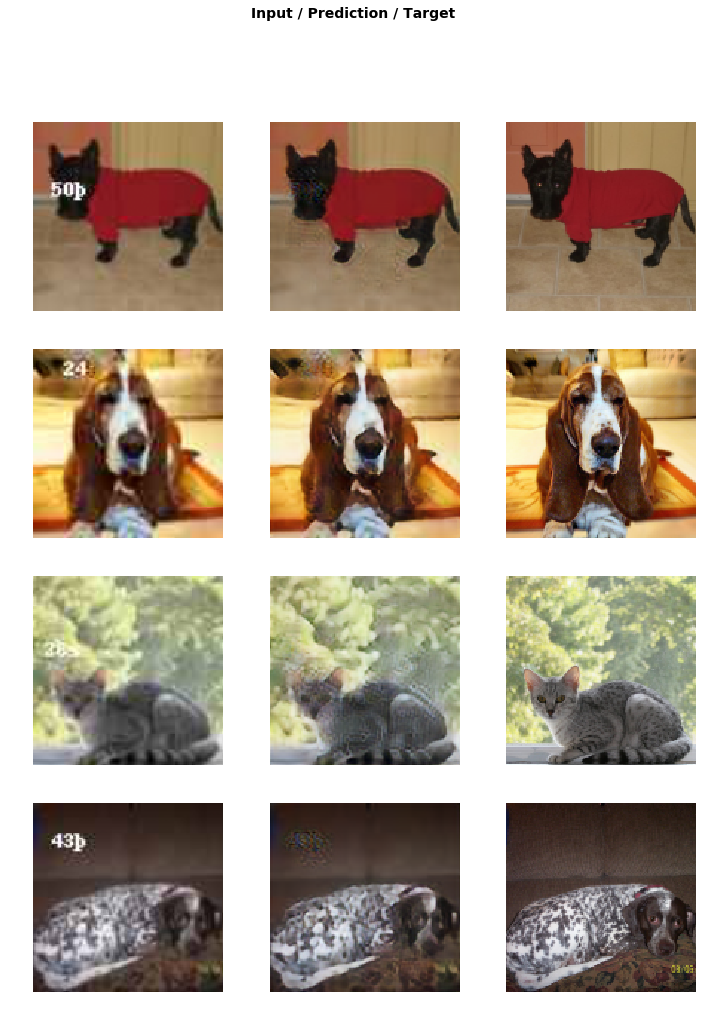

In [80]:
learn.show_results(rows=4)